## Package Import

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import seaborn as sns

from torch import nn

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

pd.options.display.max_rows = 999

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Data Import, Pre-Processing, and Exploratory Analysis

In [3]:
data = pd.read_csv('datathon4.csv')
data.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [ ]:
data.describe()

In [ ]:
data.shape

In [ ]:
data.dtypes.unique()

In [ ]:
df_num = data.select_dtypes(include=np.number)  # numeric columns
num_col = list(df_num.columns)

In [ ]:
df_obj = data.select_dtypes(include=np.object)   # object columns
obj_col = list(df_obj.columns)

In [ ]:
data.isna().sum()

**Sample size of 91713 unique patients**  
In other words, no patients have repeated measurements. So the model will not have to worry about correlation within individuals.

In [4]:
# Drop Ids
data = data.drop(columns=['encounter_id', 'patient_id', 'hospital_id'])
data = pd.get_dummies(data, columns=['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'apache_3j_bodysystem', 'apache_2_bodysystem'])

In [ ]:
data['patient_id'].nunique()

No missing data on our outcome of interest - hospital deaths, however, lots of missing for predictor variables.
*   No observations will be dropped
*   Impute predictors that have missing values or drop ones that have no association with hospital death

In [ ]:
df_obj.isna().sum()
missing_list = data.columns[data.isnull().any()].tolist()  # all columns that have missing values
num_col_missing = np.intersect1d(num_col, missing_list) # all numeric columns with missing
obj_col_missing = np.intersect1d(obj_col, missing_list) # object cols

### Demographics Variables

In [ ]:
df_dem = data.iloc[:, 4:18]
df_dem.head()

In [ ]:
df_dem = df_dem.join(data['hospital_death'])

In [ ]:
df_dem.isna().sum()

In [ ]:
data['ethnicity'].unique()
sns.barplot(data, x='ethnicity', y='hospital_death')

In [ ]:
data['gender'].unique()
sns.barplot(data, x='gender', y='hospital_death')

In [ ]:
data['hospital_admit_source'].unique()
sns.barplot(data, x='hospital_admit_source', y='hospital_death') # may be worth imputing, but depends on if missing for a reason

In [ ]:
sns.boxplot(data, x='hospital_death', y='age')

In [ ]:
sns.histplot(df_dem, x='bmi')

In [ ]:
sns.boxplot(data, x='hospital_death', y='bmi')

In [ ]:
sns.barplot(data, x='icu_admit_source', y='hospital_death')

Impute object columns with mode, numerical with median

In [ ]:
for col in obj_col_missing:
  data[col].fillna(data[col].mode(), inplace=True)
for col in num_col_missing:
  data[col].fillna(data[col].median(), inplace=True)

Dummy code categorical variables

In [ ]:
df_final = pd.get_dummies(data, columns = obj_col, drop_first=True)

Pairwise associations plots

In [ ]:
sns.pairplot(df_dem, hue='hospital_death')

In [ ]:
data.describe()

If using other apache variables, don't use variables **apache_4a_hospital_death_prob**, and **apache_4a_icu_death_prob**	since these are prediction probabilities of mortality using other apache scores. Suspect this will be near perfect indicators of hospital death.

In [ ]:
df_ap = data.iloc[:, 18:46]
df_ap = df_ap.join(data['hospital_death'])
df_ap.head()

In [ ]:
data.shape

### Comorbidity variables

In [ ]:
df_como = data.iloc[:, 176:186]
df_como = df_como.join(data['hospital_death'])

In [ ]:
sns.pairplot(df_como, hue="hospital_death")

### Lab Blood Gas Variables

In [ ]:
df_labgas = data.iloc[:, 158:173]
df_labgas = df_labgas.join(data['hospital_death'])
df_labgas.head()

### Labs Variables

In [ ]:
df_lab = data.iloc[:, 98:158]
df_lab = df_lab.join(data['hospital_death'])
df_lab.head()

In [ ]:
df_vitals = data.iloc[:, 46:98]
df_vitals = df_vitals.join(data['hospital_death'])
df_vitals.head()

**Correlation matrices** by class of variables.


*   All have hospital_death appended to them, so we can see association with our response variable



In [ ]:
sns.heatmap(df_dem.corr())  # demographic

In [ ]:
sns.heatmap(df_ap.corr())  # apache

In [ ]:
sns.heatmap(df_como.corr())  # comborbidity

In [ ]:
sns.heatmap(df_labgas.corr())  # lab gas

In [ ]:
sns.heatmap(df_vitals.corr())  # vitals

In [ ]:
sns.heatmap(df_lab.corr()) # labs

**df_final** is the final version of the processed dataset to be used for the next modelling steps.

## NEURAL NET

In [6]:
# Randomly sample 70% of the data for training
train_data = data.sample(frac = .7, random_state=10)

# Use the remaining 30% for testing
test_data = data.drop(train_data.index)

# Check the mean of the 'hospital_death' column in both training and testing data
train_data['hospital_death'].mean()
test_data['hospital_death'].mean()

# Extract the 'hospital_death' column as the target variable for training and testing
Y_train = train_data['hospital_death'].to_numpy()
Y_test = test_data['hospital_death'].to_numpy()

# Extract the features (excluding 'hospital_death') for training and testing
X_train = train_data.drop('hospital_death', axis=1).to_numpy()
X_test = test_data.drop('hospital_death', axis=1).to_numpy()

# Standardize the features to have zero mean and unit variance
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Transforming to Tensors and sending to cuda
X_train = torch.Tensor(X_train).type(torch.float32).to(device)
X_test = torch.Tensor(X_test).type(torch.float32).to(device)
Y_train = torch.Tensor(Y_train).type(torch.float32).to(device)
Y_test = torch.Tensor(Y_test).type(torch.float32).to(device)

In [7]:
# Create a dataset from tensors to be used with DataLoader
train_data = TensorDataset(X_train, Y_train)
test_data = TensorDataset(X_test, Y_test)

# Defining the parameters
epochs = 100
learning_rate = 0.01
batch_size = 32

# DataLoader provides batches of data for training
train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [8]:
class NeuralNetwork(nn.Module): # Model inherits from nn.Module
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(234, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.linear_relu_stack(x)
        

# Define the neural network, optimizer, and loss function
model = NeuralNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.BCELoss()

# Lists to store accuracy values during training
train_accuracy_list = []
validation_accuracy_list = []

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred.view(-1), y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # if batch % 100 == 0:
        #     loss, current = loss.item(), (batch + 1) * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred.view(-1), y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    validation_accuracy_list.append(100*correct)
    #print(f"Test Error: \n Accuracy: {():>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [9]:
for t in range(epochs):
    print(f"Epoch {t+1}\n")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

KeyboardInterrupt: 

Text(0, 0.5, 'Accuracy')

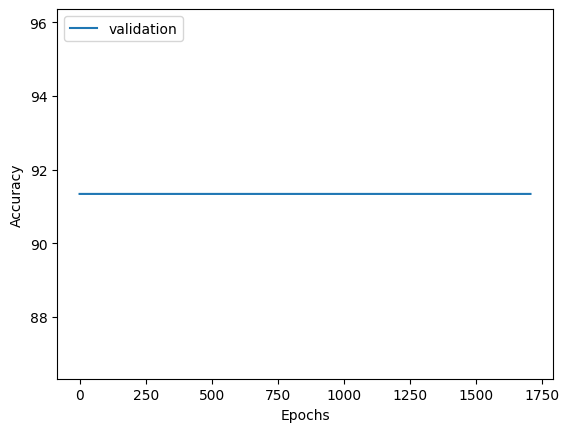

In [10]:
# Plotting the training and validation accuracy
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label='validation')
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')